# Building the distribution from Classifier

## Loading Data, Libraries and Models

### Import Libraries

In [2]:
import pandas as pd 
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
print(pd.__version__)
import progressbar
import os
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chisquare

1.2.3


### Load data

In [3]:
from process import loaddata
class_data = loaddata("../data/all/{}.csv".format('latest'))

In [4]:
np.random.shuffle(class_data)
xc = class_data

### Load model

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers

In [6]:
model_class = models.load_model('../models/classifier/latest_dropout.h5')

## Obtain probability predictions

In [7]:
y_prob = model_class.predict(xc)

### Prepare for binning
#### Obtain the max and min boundaries

In [8]:
max_c = [] 
min_c = []
for i in range(len(xc[0])):
    max_c.append(np.amax(xc[:,i]))
    min_c.append(np.amin(xc[:,i]))

In [9]:
max_c

[2.462254047393799,
 2.5889649391174316,
 2.4499003887176514,
 1.8787336349487305,
 2.2381997108459473,
 1.9636166095733643,
 3.9999990463256836,
 3.999994993209839,
 3.9999961853027344,
 3.999998092651367]

## Average accross x dimensions

In [10]:
def energy_photon(electron, photon):
    electron = np.array(electron, dtype = np.longdouble)
    
    g_e_L = np.sqrt(electron[0]**2 + electron[1]**2 + electron[2]**2 +1)
    v_e_L = electron/g_e_L
    #print(v_e_L)
    #print(g_e_L)
    
    photon = np.array(photon, dtype = np.longdouble)
    g_p_L = np.linalg.norm(photon)
    v_p_L = photon/g_p_L
   # print(v_p_L)  
   # print(g_p_L)
    
    u_g_E = g_e_L * g_p_L - electron[0]*photon[0] - electron[1]*photon[1] -electron[2]*photon[2]
    return g_e_L, g_p_L

In [11]:
energy_photon([0.2,0.1,0.511], [0.2, 0.1, 0.511])

(1.1450419206299828809, 0.5577822155644620546)

In [13]:
x_p = []
x_e = []
for pair, y in zip(xc, y_prob):
    a, b = energy_photon(pair[0:3], pair[3:6])
    x_e.append(a)
    x_p.append(b) 
x_e = np.array(x_e)
x_p = np.array(x_p)

In [14]:
print(x_p.shape)
print(x_e.shape)

(809484,)
(809484,)


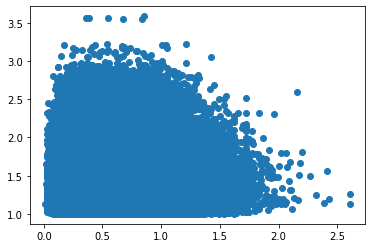

In [15]:
plt.scatter(x_p, x_e)

In [40]:
res = 124
step_p = (np.amax(x_p)-np.amin(x_p))/res
step_e = (np.amax(x_e)-np.amin(x_e))/res
xp_x = []
xe_x = []

for i in range(res):
    xp_x.append(np.amin(x_p) + step_p*i)
    xe_x.append(np.amin(x_e) + step_e*i)
    
def wbin(p,e):
    idp = math.trunc(float((p-np.amin(x_p))/step_p))
    ide = math.trunc(float((e-np.amin(x_e))/step_e))
    if idp == res: idp = res-1
    if ide == res: ide = res-1
    return idp, ide

In [41]:
bins = []
bins_count = []

for i in range(res):
    bins_p = []
    for j in range(res):
        bins_p.append([])
    bins.append(bins_p)
    
for (p, e), y in zip(zip(x_p,x_e), y_prob[:40000]):
    idp, ide = wbin(p,e)
    bins[idp][ide].append(y)

In [42]:
sum_total = []
for bi in range(res):
    sum_ = []
    for bi_ in range(res):
        sum_.append(np.sum(bins[bi][bi_]))
    sum_total.append(sum_)

In [48]:
np.array(sum_total).shape

(124, 124)

In [53]:
X, Y = np.meshgrid(xp_x, xe_x)

<IPython.core.display.Javascript object>


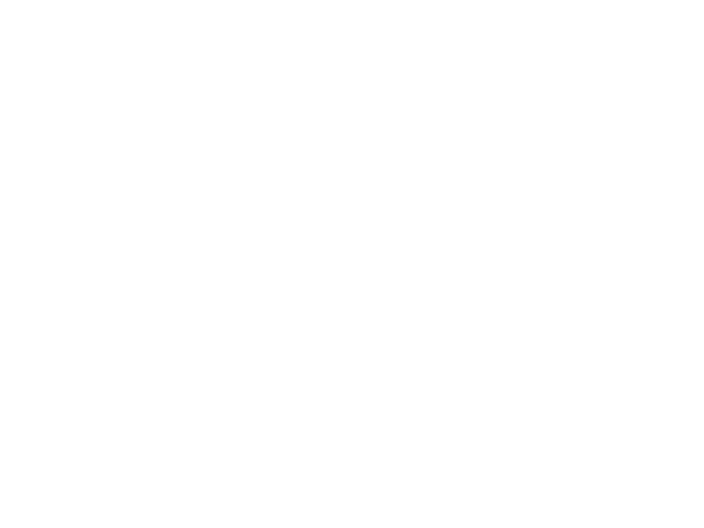

In [55]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, np.array(sum_total), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [58]:
from matplotlib import ticker, cm
plt.contourf(xp_x, xe_x, sum_total, locator=ticker.LogLocator())
plt.xlim(0,1.5)
plt.ylim(0.9,2.5)

<ipython-input-58-5c355254a06f>:2: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xp_x, xe_x, sum_total, locator=ticker.LogLocator())


(0.9, 2.5)